<a href="https://colab.research.google.com/github/Meta-Sean/Practical-Deep-Learning/blob/main/space_titanic_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space Titanic
- Predict which passengers are transported to an alternate dimension

# File and Data Field Descriptions
- train.csv - Personal records for about two-thirds (~8700) of the    passengers, to be used as training data.
  - PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
  - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
  - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
  - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
  - Destination - The planet the passenger will be debarking to.
  - Age - The age of the passenger.
  - VIP - Whether the passenger has paid for special VIP service during the voyage.
  - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
  - Name - The first and last names of the passenger.
  - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
- test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
  - PassengerId - Id for each passenger in the test set.
  - Transported - The target. For each passenger, predict either True or False.



In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
import pandas as pd
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
! mkdir ~/.kaggle #creating folder
! cp kaggle.json ~/.kaggle/ #copying kaggle.json
! chmod 600 ~/.kaggle/kaggle.json #reading the file with full access

In [4]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/spaceship-titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('spaceship-titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 299k/299k [00:00<00:00, 47.7MB/s]

In [5]:
df = pd.read_csv('spaceship-titanic/train.csv')
tst_df = pd.read_csv('spaceship-titanic/test.csv')
modes = df.mode().iloc[0]
df['Transported'] = df['Transported'].apply(lambda x: 1 if x == True else 0)

## Data preprocessing

In [6]:
import numpy as np

def add_features(df):
  df.fillna(modes, inplace=True)
  df['LogRoomService'] = np.log(df['RoomService']+1)
  df['LogFoodCourt'] = np.log(df['FoodCourt']+1)
  df['LogShoppingMall'] = np.log(df['ShoppingMall']+1)
  df['LogSpa'] = np.log(df['Spa']+1)
  df['LogVRDeck'] = np.log(df['VRDeck']+1)
  df[['Deck','CabinNumber','Side']] = df.Cabin.str.split('/', expand=True)
  df[['Group', 'PassengerNumber']] = df.PassengerId.str.split('_', expand=True)

add_features(df)
add_features(tst_df)

In [7]:
def proc_data(df):
  df.fillna(modes, inplace=True)
  df['HomePlanet'] = pd.Categorical(df.HomePlanet)
  df["CryoSleep"] = pd.Categorical(df.CryoSleep)
  df['Destination'] = pd.Categorical(df.Destination)
  df['Deck'] = pd.Categorical(df.Deck)
  df['CabinNumber'] = pd.Categorical(df.HomePlanet)
  df['Side'] = pd.Categorical(df.Side)
  df['Group'] = pd.Categorical(df.Group)
  df['PassengerNumber'] = pd.Categorical(df.PassengerNumber)
  

proc_data(df)
proc_data(tst_df)


In [8]:
cats=["HomePlanet", "CryoSleep", "Destination", "Deck", "CabinNumber", "Side", "Group", "PassengerNumber"]
conts=['Age', 'LogRoomService', 'LogFoodCourt', 'LogShoppingMall', 'LogSpa', 'LogVRDeck']
dep="Transported"

In [9]:
df.CryoSleep.head()

0    False
1    False
2    False
3    False
4    False
Name: CryoSleep, dtype: category
Categories (2, object): [False, True]

In [10]:
df.CryoSleep.cat.codes.head()

0    0
1    0
2    0
3    0
4    0
dtype: int8

## Binary splits

[Text(0.5, 1.0, 'Histogram')]

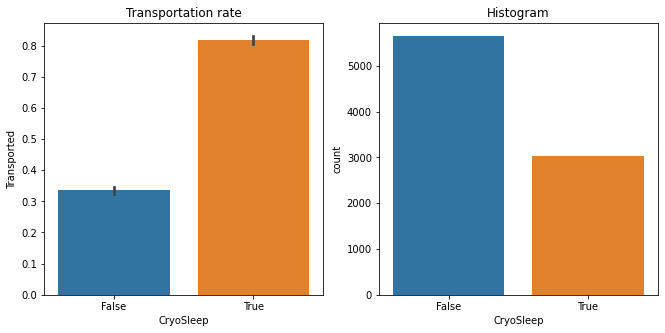

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fix,axs = plt.subplots(1, 2, figsize=(11, 5))
sns.barplot(data=df, y=dep, x="CryoSleep", ax=axs[0]).set(title="Transportation rate")
sns.countplot(data=df, x='CryoSleep', ax=axs[1]).set(title='Histogram')

In [12]:
 from numpy import random
 from sklearn.model_selection import train_test_split
 
 random.seed(42)
 trn_df, val_df = train_test_split(df, test_size=0.25)
 trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
 val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [13]:
def xs_y(df):
  xs = df[cats+conts].copy()
  return xs, df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

In [14]:
preds = val_xs.CryoSleep==1
val_y

304     1
2697    0
8424    0
1672    1
8458    1
       ..
4478    1
2996    1
7760    1
8181    0
8420    0
Name: Transported, Length: 2174, dtype: int64

In [15]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.2755289788408464

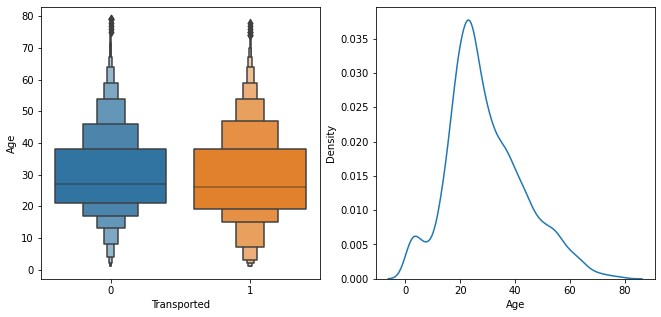

In [16]:
df_age = trn_df[trn_df.Age>0]
fig, axs = plt.subplots(1,2, figsize=(11, 5))
sns.boxenplot(data=df_age, x=dep, y="Age", ax=axs[0])
sns.kdeplot(data=df_age, x="Age", ax=axs[1]);

## Not really conclusive quantiles for age and transportation
Lets write a score function to try out a few different splits

In [17]:
def _side_score(side, y):
  tot = side.sum()
  if tot<=1: return 0
  return y[side].std()*tot

In [18]:
def score(col, y, split):
  lhs = col<=split
  return (_side_score(lhs, y) + _side_score(~lhs, y))/len(y)

In [19]:
score(trn_xs["CryoSleep"], trn_y, 0.5)

0.4427274084379482

In [20]:
score(trn_xs['Age'], trn_y, 20)

0.49837479646647287

In [21]:
def iscore(nm, split):
  col = trn_xs[nm]
  return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'LogRoomService', 'LogFoodCourt', 'LogShoppin…

In [22]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'C…

## Instead of manually doing this lets write a function that can automatically find the best split point for all our columns

In [23]:
def min_col(df, nm):
  col, y = df[nm], df[dep]
  unq = col.dropna().unique()
  scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
  idx = scores.argmin()
  return unq[idx], scores[idx]

min_col(trn_df, "Age")

(5.0, 0.49588222217088634)

In [24]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'HomePlanet': (0, 0.49262732535926257),
 'CryoSleep': (0, 0.4427274084379482),
 'Destination': (0, 0.4975146234286769),
 'Deck': (2, 0.49146596918858604),
 'CabinNumber': (0, 0.49262732535926257),
 'Side': (0, 0.4972039930912765),
 'Group': (2054, 0.4988487272764558),
 'PassengerNumber': (0, 0.4982305020633713),
 'Age': (5.0, 0.49588222217088634),
 'LogRoomService': (0.0, 0.4712139445780011),
 'LogFoodCourt': (0.0, 0.4864171323280328),
 'LogShoppingMall': (0.0, 0.4838374399256237),
 'LogSpa': (0.0, 0.46960050421496596),
 'LogVRDeck': (0.0, 0.47094236980183707)}

# Decision Tree!!!

In [25]:
trn_df.isnull().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Transported        0
LogRoomService     0
LogFoodCourt       0
LogShoppingMall    0
LogSpa             0
LogVRDeck          0
Deck               0
CabinNumber        0
Side               0
Group              0
PassengerNumber    0
dtype: int64

In [26]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [27]:
import graphviz
import re

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

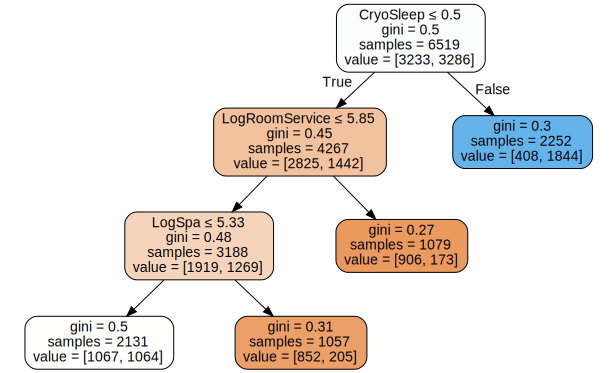

In [28]:
draw_tree(m, trn_xs, size=10)

In [29]:
def gini(cond):
  act = df.loc[cond, dep]
  return 1 - act.mean()**2 - (1-act).mean()**2

In [30]:
gini(df.CryoSleep==0), gini(df.CryoSleep==1)

(0.4455780020566211, 0.2982818967776309)

In [31]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2755289788408464

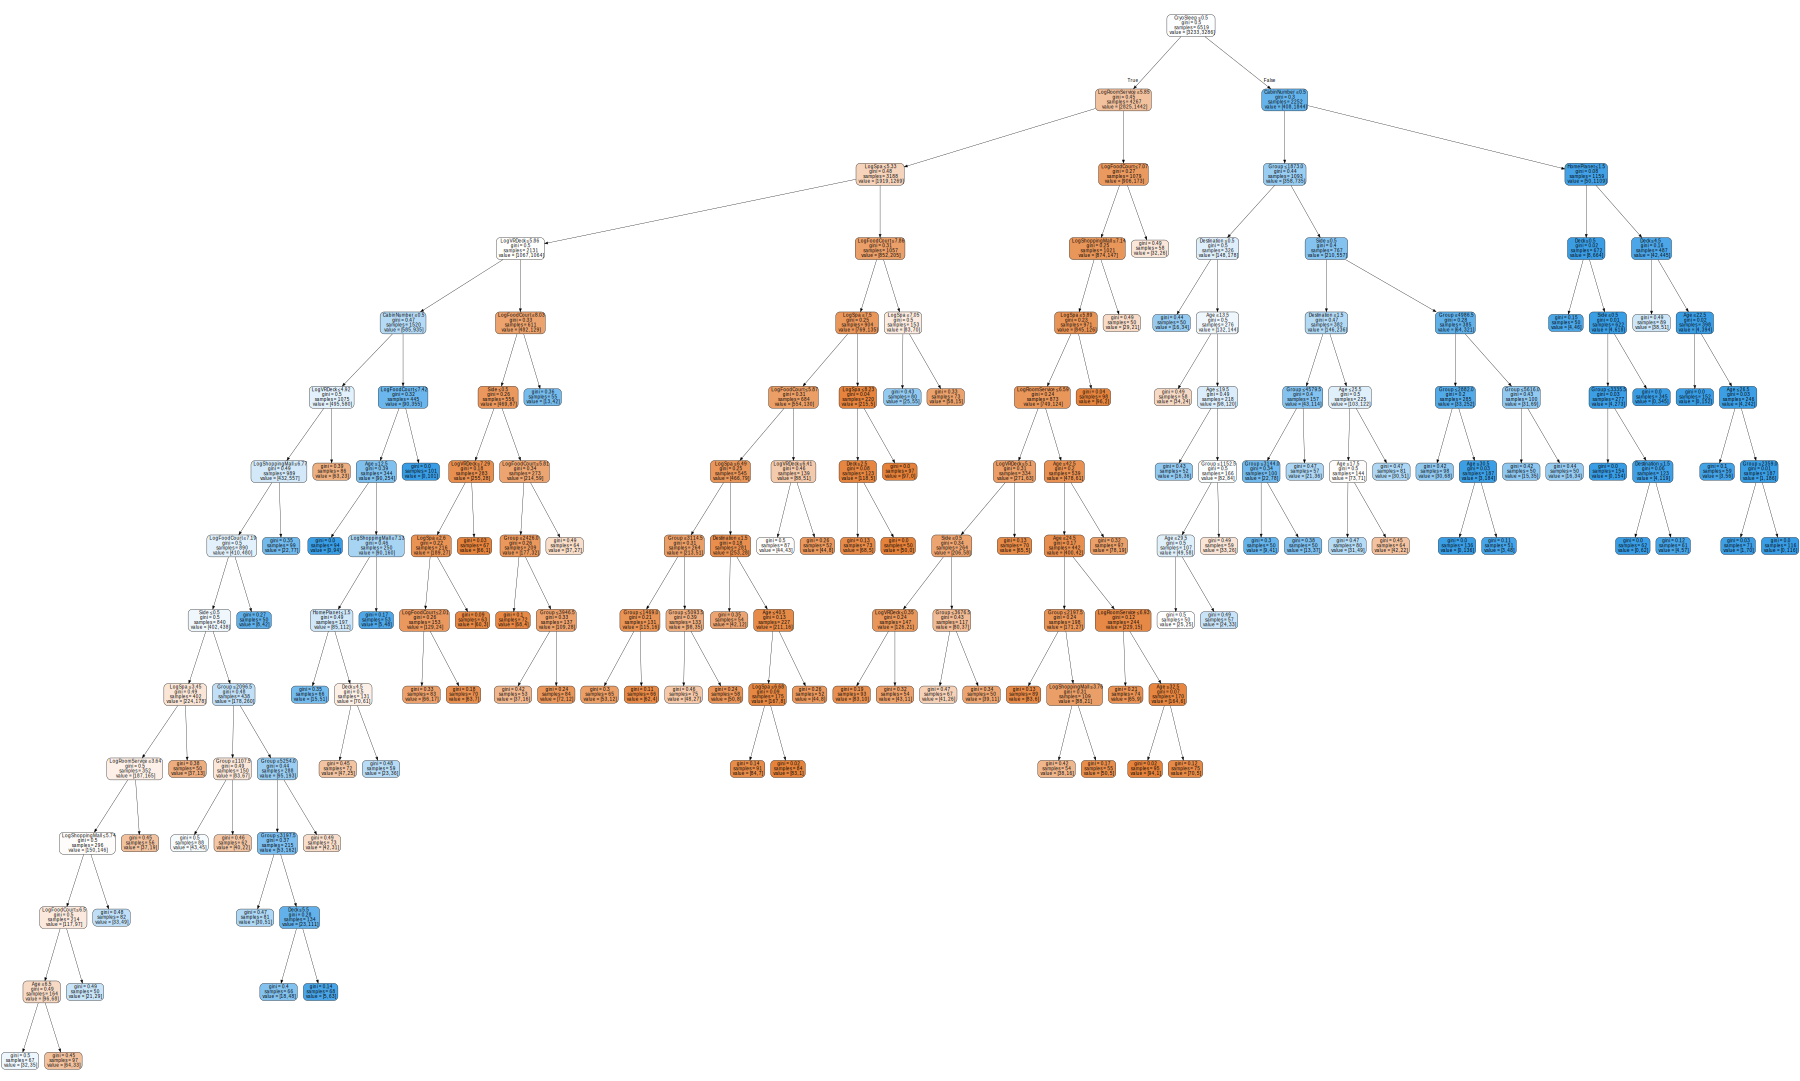

In [32]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=25)

In [33]:
mean_absolute_error(val_y, m.predict(val_xs))

0.21573137074517018

In [34]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
  tst_df['Transported'] = list(map(lambda x: True if x == 1 else False, preds))
  sub_df = tst_df[['PassengerId', 'Transported']]
  sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

In [35]:
#! kaggle competitions submit -c spaceship-titanic -f sub-tree.csv -m 'decision tree'

# Random Forest

In [36]:
def get_tree(prop=0.75):
  n = len(trn_y)
  idxs = random.choice(n, int(n*prop))
  return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [37]:
trees = [get_tree() for t in range(100)]

In [38]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.25528978840846367

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y)
mean_absolute_error(val_y, rf.predict(val_xs))

0.20791168353265868

In [40]:
subm(rf.predict(tst_xs), 'rf')

In [41]:
#! kaggle competitions submit -c spaceship-titanic -f sub-rf.csv -m 'random forest'

100% 56.5k/56.5k [00:03<00:00, 16.5kB/s]
Successfully submitted to Spaceship Titanic

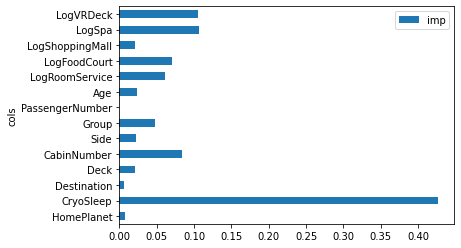

In [42]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh')

In [43]:
from sklearn.model_selection import cross_val_score

## XG Boost

In [60]:
import xgboost as xgb
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.001,
                max_depth = 8, alpha = 1, n_estimators = 400)

scores = cross_val_score(xg_reg, trn_xs, trn_y, cv=5)
scores.mean()

0.8022713040694198

In [58]:
xg_reg.fit(trn_xs, trn_y)
subm(xg_reg.predict(tst_xs), 'xgb')

In [59]:
! kaggle competitions submit -c spaceship-titanic -f sub-xgb.csv -m 'xbg'

100% 56.5k/56.5k [00:03<00:00, 16.7kB/s]
Successfully submitted to Spaceship Titanic

# Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(random_state=0,max_iter=500)
scores = cross_val_score(clf, trn_xs, trn_y, cv=5)
scores.mean()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.7765018433158026

In [46]:
import tensorflow as tf
from tensorflow import keras

In [55]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(14,)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(24, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) 

In [56]:
model.fit(trn_xs, trn_y, epochs=10, batch_size=10, validation_split=0.2)

Epoch 1/10
522/522 [==============================] - 2s 2ms/step - loss: 1.4381 - accuracy: 0.5866 - val_loss: 0.6005 - val_accuracy: 0.7531
Epoch 2/10
522/522 [==============================] - 1s 2ms/step - loss: 1.2813 - accuracy: 0.6293 - val_loss: 1.8959 - val_accuracy: 0.5790
Epoch 3/10
522/522 [==============================] - 1s 2ms/step - loss: 1.2259 - accuracy: 0.6545 - val_loss: 0.7641 - val_accuracy: 0.7002
Epoch 4/10
522/522 [==============================] - 1s 2ms/step - loss: 1.0225 - accuracy: 0.6780 - val_loss: 0.5924 - val_accuracy: 0.7569
Epoch 5/10
522/522 [==============================] - 1s 2ms/step - loss: 0.9770 - accuracy: 0.6704 - val_loss: 1.0568 - val_accuracy: 0.6235
Epoch 6/10
522/522 [==============================] - 1s 2ms/step - loss: 0.9368 - accuracy: 0.6842 - val_loss: 0.5072 - val_accuracy: 0.7899
Epoch 7/10
522/522 [==============================] - 1s 2ms/step - loss: 1.0708 - accuracy: 0.6842 - val_loss: 0.5836 - val_accuracy: 0.7538
Epoch 

In [54]:
trn_xs.shape

(6519, 14)